In [1]:
from scipy.special import kl_div,rel_entr
import numpy as np
from matplotlib import pyplot as plt
import quantum_classical_2Dgamma as qc

import tensorflow as tf
from matplotlib import pyplot
from qibo import gates, hamiltonians, models, set_backend, set_threads
from matplotlib import cm
from matplotlib import pyplot as plt, colors
from matplotlib.offsetbox import AnchoredText
import pandas as pd

[Qibo 0.1.7|INFO|2022-04-18 10:02:02]: Using tensorflow backend on /device:CPU:0
[Qibo 0.1.7|WARNING|2022-04-18 10:02:02]: qibotf library was not found. `tf.einsum` will be used to apply gates. In order to install Qibo's high performance custom operators for TensorFlow please use `pip install qibotf`. Alternatively, consider installing the qibojit backend.
[Qibo 0.1.7|INFO|2022-04-18 10:02:02]: Using tensorflow backend on /device:CPU:0


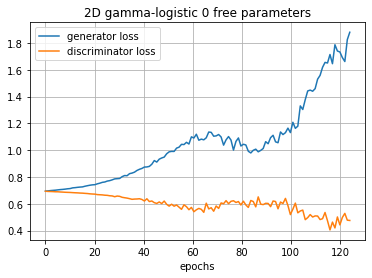

In [8]:
d_loss = np.loadtxt(f"dloss_2Dgaussian_2_3_1_10000_{n_layers}_0.5_10", delimiter=' ')
g_loss= np.loadtxt(f"gloss_2Dgaussian_2_3_1_10000_{n_layers}_0.5_10", delimiter=' ')
    #d_loss=d_loss[:10000]
    #g_loss=g_loss[:10000]
    #pyplot.figure(figsize=(20, 7), dpi=80)
pyplot.plot(np.linspace(0, len(g_loss), len(g_loss)), g_loss, label='generator loss')
pyplot.plot(np.linspace(0, len(g_loss), len(g_loss)), d_loss, label='discriminator loss')
pyplot.title(f'2D gamma-logistic {12-val} free parameters')
pyplot.xlabel('epochs')
pyplot.legend()
pyplot.grid()



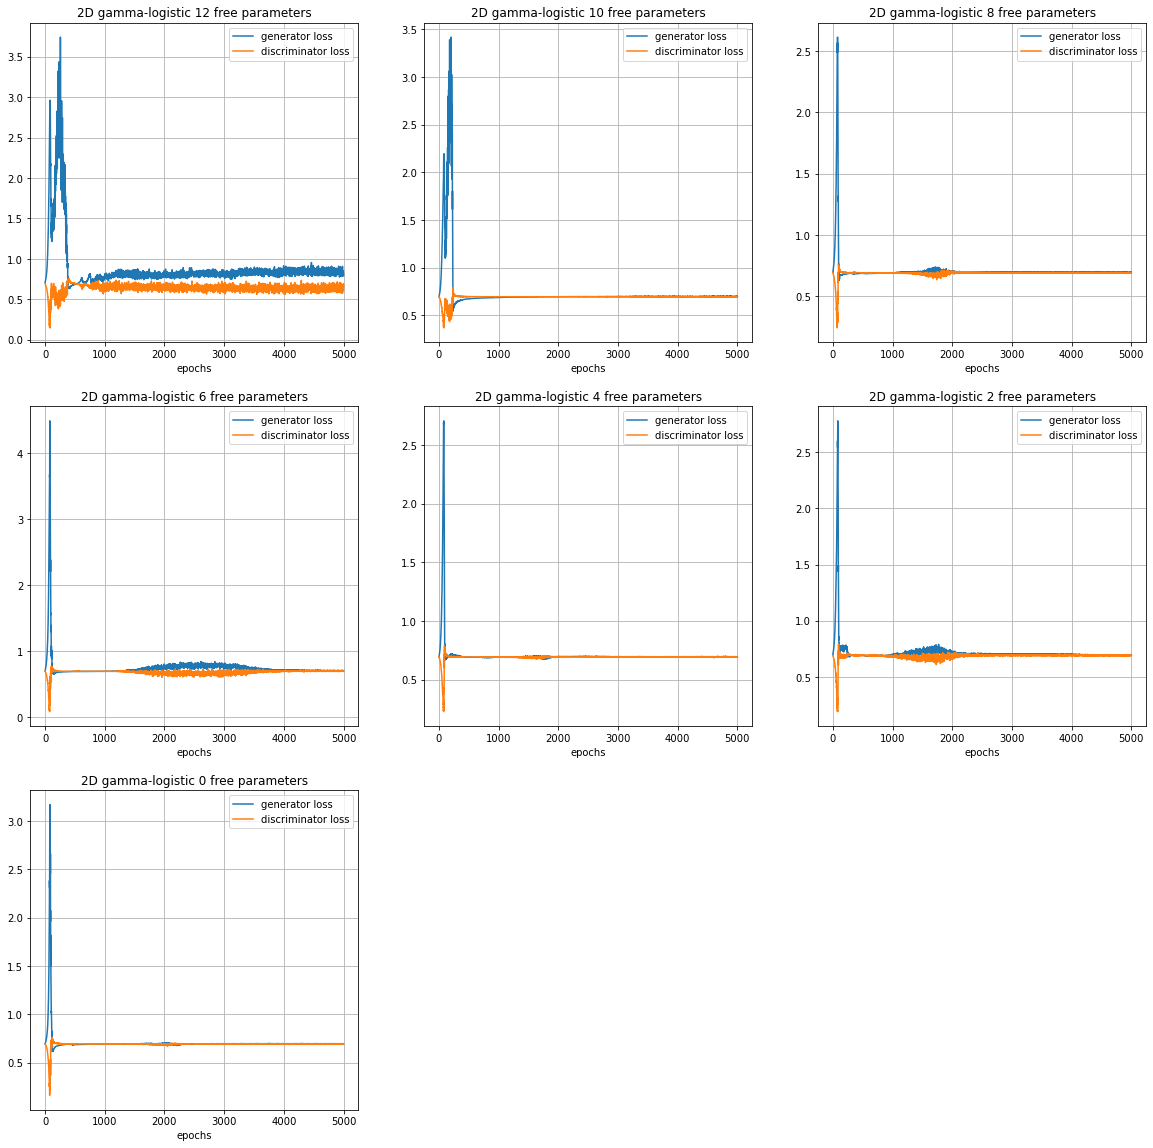

In [2]:
n_layers=128
fixed_params=range(0,14,2)
pyplot.figure(figsize=(20,20))
rows=3
cols=3


for i, val in enumerate(fixed_params):
    pyplot.subplot(rows,cols,i+1)
    d_loss = np.loadtxt(f"dloss_2Dgaussian_2_3_1_10000_{n_layers}_0.1_{val}", delimiter=' ')
    g_loss= np.loadtxt(f"gloss_2Dgaussian_2_3_1_10000_{n_layers}_0.1_{val}", delimiter=' ')
    #d_loss=d_loss[:10000]
    #g_loss=g_loss[:10000]
    #pyplot.figure(figsize=(20, 7), dpi=80)
    pyplot.plot(np.linspace(0, len(g_loss), len(g_loss)), g_loss, label='generator loss')
    pyplot.plot(np.linspace(0, len(g_loss), len(g_loss)), d_loss, label='discriminator loss')
    pyplot.title(f'2D gamma-logistic {12-val} free parameters')
    pyplot.xlabel('epochs')
    pyplot.legend()
    pyplot.grid()

pyplot.show()

In [11]:
print(qc.load_fixed_params(12))

[-4.16185442e-01 -1.99874317e-01 -5.56329573e-01  1.64454349e+00
 -2.46253974e-01 -4.55325184e-01  2.59551539e-13  3.70004765e-13
 -6.47463339e-01 -6.71612792e-01 -2.95105688e-01 -4.34907444e-01]


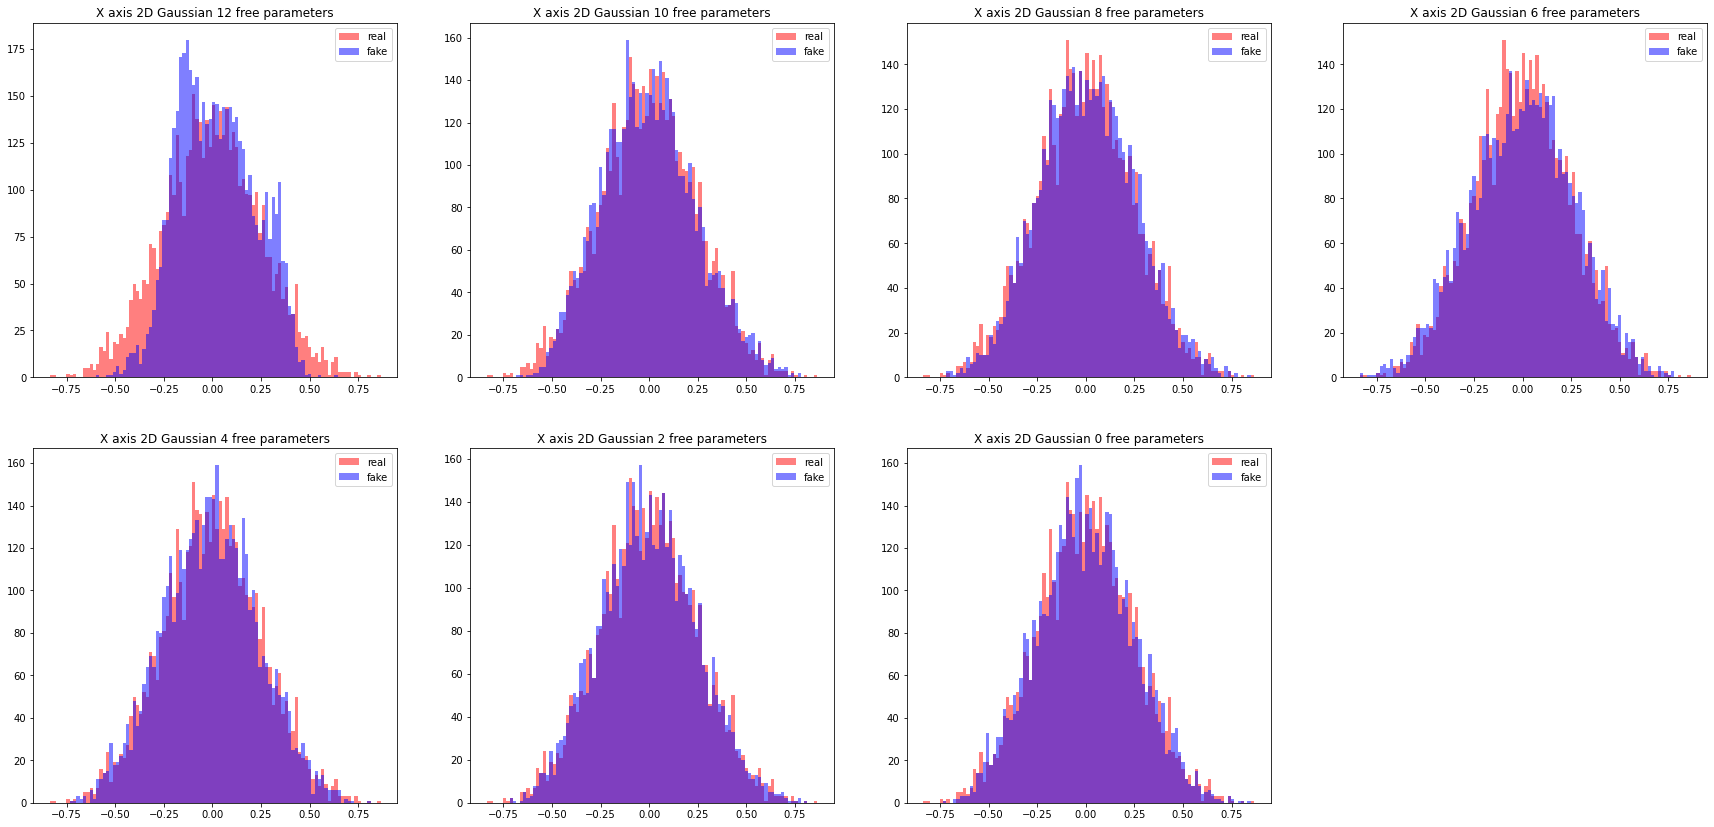

In [18]:
def hamiltonian1():
        id = [[1, 0], [0, 1]]
        m0 = hamiltonians.Z(1).matrix
        m0 = np.kron(id, m0)
        ham = hamiltonians.Hamiltonian(2, m0)
        return ham
    
def hamiltonian2():
        id = [[1, 0], [0, 1]]
        m0 = hamiltonians.Z(1).matrix
        m0 = np.kron(m0,id)
        ham = hamiltonians.Hamiltonian(2, m0)
        return ham
    
def kl_divergence(bins_real, bins_fake,epsilon):
    
    epsilon=0.1
    prob_real=[]
    prob_fake=[]
    for i in range (len(bins_real)):
        prob_real.append(bins_real[i]+epsilon)
        prob_fake.append(epsilon+bins_fake[i])

    #print(prob_fake,prob_real)  

    prob_real=prob_real/sum(prob_real) # probability for each bin (Normalization)
    prob_fake=prob_fake/sum(prob_fake)

   
    return sum(prob_real[i] * np.log(prob_real[i]/prob_fake[i]) for i in range(len(prob_real)))# Convergence problem if a[i] or b[i] equals zero. 
                                                            #I add a little quantity to each bin to avoid problems
   

nqubits = 2
latent_dim=3
samples=5000
layers=1
nbins=100
training_samples=5000



# create hamiltonians
    
hamiltonian1 = hamiltonian1()
hamiltonian2 = hamiltonian2()
   
# create quantum generator
circuit = models.Circuit(nqubits)
for l in range(layers):
    for q in range(nqubits):
        circuit.add(gates.RY(q, 0))
        circuit.add(gates.RZ(q, 0))
        
    #circuit.add(gates.CRY(0, 1, 0))
            
for q in range(nqubits):
    circuit.add(gates.RY(q, 0))

fig = plt.figure(figsize=(30,30))

distributionsX=[]
distributionsY=[]

real_distr,_ = qc.generate_real_samples(samples, s, training_samples)
real_distr=tf.transpose(real_distr)

distributionsX.append(real_distr[0])
distributionsY.append(real_distr[1])

for i, val in enumerate(fixed_params):
    
    pyplot.subplot(rows,cols,i+1)
    
    params = np.loadtxt(f"PARAMS_2Dgaussian_2_3_1_10000_{n_layers}_0.1_{val}", delimiter=' ', unpack='true')

    params = tf.Variable(params)

    fake_distr, _ = qc.generate_fake_samples(params, latent_dim, samples, circuit, nqubits, layers, hamiltonian1,hamiltonian2,10)
    fake_distr=tf.transpose(fake_distr)
    
    s = qc.generate_training_real_samples(training_samples)

    
    distributionsX.append(fake_distr[0])
    distributionsY.append(fake_distr[1])

    bins_real=pyplot.hist(real_distr[0].numpy(), color='red', bins=nbins,label='real', alpha=0.5)
    bins_fake=pyplot.hist(fake_distr.numpy()[0], bins=bins_real[1],color='blue', label='fake', alpha=0.5)

    pyplot.legend()
    pyplot.title(f"X axis 2D Gaussian {12-val} free parameters")
    at = AnchoredText(
        f"KL div: {'%.3f' %kl_divergence(bins_real[0],bins_fake[0],epsilon=0.1)}", prop=dict(size=15), frameon=True, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)

pyplot.show()

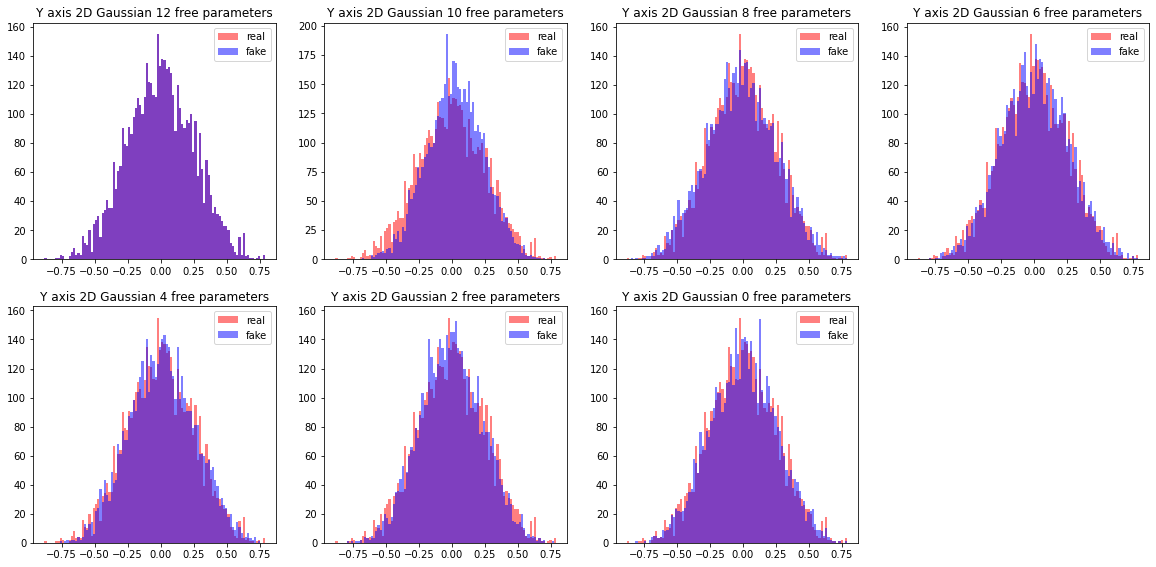

In [19]:
fig = plt.figure(figsize=(30,30))

for i, val in enumerate(fixed_params):
    
    pyplot.subplot(rows,cols,i+1)
    
    bins_real=pyplot.hist(distributionsY[0].numpy(), color='red', bins=nbins,label='real', alpha=0.5)
    bins_fake=pyplot.hist(distributionsY[i].numpy(), bins=bins_real[1],color='blue', label='fake', alpha=0.5)

    pyplot.legend()
    pyplot.title(f"Y axis 2D Gaussian {12-val} free parameters")

    at = AnchoredText(
        f"KL div: {'%.3f' %kl_divergence(bins_real[0],bins_fake[0],epsilon=0.1)}", prop=dict(size=15), frameon=True, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)


pyplot.show()

In [6]:
from IPython.display import display
from scipy import stats

moments = pd.DataFrame(
    {
        "distribution":["real x","real y","fake x","fake y" ],
        "mean":[np.mean(i) for i in distributions],
        "2 moment ":[stats.moment(i,moment=2) for i in distributions],
        "3 moment":[stats.moment(i,moment=3) for i in distributions],
        "4 moment ":[stats.moment(i,moment=4) for i in distributions]
    }
)
display(moments)

,distribution,mean,2 moment,3 moment,4 moment
0,real x,-0.002022,0.063867,-0.001402,0.012551
1,real y,0.002129,0.064051,0.000034,0.012224
2,fake x,-0.012463,0.058436,0.001120,0.009252
3,fake y,-0.017706,0.052034,-0.000407,0.007498
